In [5]:
%pip install augini

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import os
import sys
from augini import DataEngineer, DataAnalyzer

# Input your api key
def get_api_key():
    api_key = os.environ.get('OPENROUTER_TOKEN')
    if api_key:
        print("Using API key from environment variable.")
        return api_key
    else:
        api_key = input("Enter your API key manually: ")
        return api_key

# Set up Augini components
api_key = get_api_key()

# Initialize both components with shared configuration
engineer = DataEngineer(
    api_key=api_key,
    model="gpt-4o-mini",  # Updated model name format
    temperature=0.8,      # Default temperature for better results
    max_tokens=750,       # Added parameter
    concurrency_limit=10, # Increased for better performance
    base_url="https://openrouter.ai/api/v1",  # We can use openrouter 
    debug=False
)


Using API key from environment variable.


In [2]:
# Create a sample customer dataset
np.random.seed(42)
n_customers = 50

data = {
    'CustomerID': [f'C{i:04d}' for i in range(1, n_customers + 1)],
    'Age': np.random.randint(18, 80, n_customers),
    'Tenure': np.random.randint(0, 10, n_customers),
    'MonthlyCharges': np.random.uniform(20, 200, n_customers).round(2),
    'TotalCharges': np.random.uniform(100, 5000, n_customers).round(2),
    'Contract': np.random.choice(['Month-to-month', 'One year', 'Two year'], n_customers),
    'PaymentMethod': np.random.choice(['Electronic check', 'Mailed check', 'Bank transfer', 'Credit card'], n_customers),
    'Churn': np.random.choice([0, 1], n_customers, p=[0.7, 0.3])  # 30% churn rate
}

df = pd.DataFrame(data)

print("Original Dataset:")
display(df.head())

Original Dataset:


,CustomerID,Age,Tenure,MonthlyCharges,TotalCharges,Contract,PaymentMethod,Churn
0,C0001,56,6,73.33,1170.36,Two year,Bank transfer,0
1,C0002,69,3,49.75,2140.90,One year,Electronic check,0
2,C0003,46,8,22.81,4428.07,Month-to-month,Electronic check,0
3,C0004,32,2,96.21,1689.29,Two year,Mailed check,1
4,C0005,60,4,91.08,698.23,Two year,Credit card,0


# 1. Data Augmentation: Add synthetic features using Augini

In [6]:
# Example 1
df = engineer.generate_feature(
    df=df,
    name='PredictedOccupation',
    description="Based on the customer's age and monthly spending patterns, suggest a likely occupation",
    output_type='text',
)

# # Example 2
df = engineer.generate_feature(
    df=df,
    name='risk_score',
    description='Calculate a risk score (0-100) based on customer behavior',
    output_type='float',
    constraints={'min': 0, 'max': 100}
)

# # Example 3: Single feature with sync processing
df = engineer.generate_feature(
    df=df,
    name='customer_segment',
    description='Classify customer into segments based on spending patterns',
    output_type='category',
    constraints={'categories': ['Premium', 'Regular', 'Budget']}
)

#  Example 4
# df = engineer.generate_feature(
#     df=df,
#     name='profile_summary',
#     description='Generate a brief description of customer profile and behavior',
#     output_type='text'
# )

  0%|          | 0/50 [00:00<?, ?it/s]

In [8]:
df = engineer.generate_feature(
    df=df,
    name='customer_segment',
    description='Classify customer into segments based on spending patterns',
    output_type='category',
    constraints={'categories': ['Premium', 'Regular', 'Budget']}
)

  0%|          | 0/50 [00:00<?, ?it/s]

In [10]:
df = engineer.generate_feature(
    df=df,
    name='profile_summary',
    description='Generate a brief description of customer profile and behavior',
    output_type='text'
)

  0%|          | 0/50 [00:00<?, ?it/s]

In [12]:
df.head(10)

,CustomerID,Age,Tenure,MonthlyCharges,TotalCharges,Contract,PaymentMethod,Churn,PredictedOccupation,customer_segment,profile_summary
0,C0001,56,6,73.33,1170.36,Two year,Bank transfer,0,Financial Analyst,Premium,Customer C0001 is a 56-year-old Financial Anal...
1,C0002,69,3,49.75,2140.90,One year,Electronic check,0,Retired Professional,Premium,Customer C0002 is a 69-year-old retired profes...
2,C0003,46,8,22.81,4428.07,Month-to-month,Electronic check,0,Mid-level Management,Budget,Customer C0003 is a 46-year-old individual wit...
3,C0004,32,2,96.21,1689.29,Two year,Mailed check,1,Young Professional,Premium,Customer C0004 is a 32-year-old young professi...
4,C0005,60,4,91.08,698.23,Two year,Credit card,0,Retired Professional,Premium,Customer C0005 is a 60-year-old retired profes...
5,C0006,25,2,72.83,1845.86,Two year,Mailed check,0,Customer Service Representative,Premium,Customer C0006 is a 25-year-old individual wit...
6,C0007,78,6,22.53,4543.46,One year,Mailed check,0,Retired,Budget,Customer ID C0007 is a 78-year-old individual ...
7,C0008,38,4,55.79,1433.45,Two year,Mailed check,0,Sales Manager,Premium,Customer C0008 is a 38-year-old Sales Manager ...
8,C0009,56,8,148.04,3273.68,Two year,Mailed check,1,Senior Management,Premium,Customer C0009 is a 56-year-old individual wit...
9,C0010,75,6,162.23,102.55,Two year,Bank transfer,1,Retired Professional,Premium,Customer C0010 is a 75-year-old retired profes...


In [13]:
# Generate all features at once
augmented_df = engineer.generate_features(
    df=df,
    features=[
        {
            'name': 'PredictedOccupation',
            'description': "Based on the customer's age and monthly spending patterns, suggest a likely occupation",
            'output_type': 'category'
        },
        {
            'name': 'ChurnReason',
            'description': 'A likely reason for churn based on customer data',
            'output_type': 'text'
        },
        {
            'name': 'RetentionOffer',
            'description': 'A personalized retention offer based on customer profile',
            'output_type': 'text'
        },
        {
            'name': 'EstimatedLTV',
            'description': 'Estimated lifetime value in dollars',
            'output_type': 'float',
            'constraints': {'min': 0}
        },
        {
            'name': 'PreferredChannel',
            'description': 'Predicted preferred communication channel',
            'output_type': 'category',
            'constraints': {'values': ['Email', 'Phone', 'SMS', 'Mail']}
        },
        {
            'name': 'BestContactTime',
            'description': 'Best time to contact the customer',
            'output_type': 'category',
            'constraints': {'values': ['Morning', 'Afternoon', 'Evening', 'Weekend']}
        }
    ],
    use_sync=False,  # Use async for better performance
    show_progress=True
)

print("\nAugmented Dataset with New Features:")
display(augmented_df.head())

  0%|          | 0/50 [00:00<?, ?it/s]


Augmented Dataset with New Features:


,CustomerID,Age,Tenure,MonthlyCharges,TotalCharges,Contract,PaymentMethod,Churn,PredictedOccupation,customer_segment,profile_summary,ChurnReason,RetentionOffer,EstimatedLTV,PreferredChannel,BestContactTime
0,C0001,56,6,73.33,1170.36,Two year,Bank transfer,0,Financial Analyst,Premium,Customer C0001 is a 56-year-old Financial Anal...,Customer is dissatisfied with customer service...,Offer a 20% discount on the next billing cycle...,3000.50,Email,Afternoon
1,C0002,69,3,49.75,2140.90,One year,Electronic check,0,Retired Professional,Premium,Customer C0002 is a 69-year-old retired profes...,Customer may feel disconnected due to lack of ...,Offer a loyalty discount of 15% for the next 6...,1000.75,Email,Afternoon
2,C0003,46,8,22.81,4428.07,Month-to-month,Electronic check,0,Mid-level Management,Budget,Customer C0003 is a 46-year-old individual wit...,Customer may consider switching due to lower p...,Offer a discount of 10% on monthly charges for...,4428.07,Email,Afternoon
3,C0004,32,2,96.21,1689.29,Two year,Mailed check,1,Young Professional,Premium,Customer C0004 is a 32-year-old young professi...,High Monthly Charges compared to competitors,25% discount on next 3 months of service,2500.75,Email,Evening
4,C0005,60,4,91.08,698.23,Two year,Credit card,0,Retired Professional,Premium,Customer C0005 is a 60-year-old retired profes...,N/A - Customer has not churned.,Exclusive discount on monthly charges for loya...,1092.96,Email,Afternoon


Key Observations:

- The **DataEngineer** generates personalized retention offers based on each customer's specific situation, considering factors like age, contract type, and perceived churn risk.
- Estimated LTV varies significantly, highlighting the importance of tailored retention strategies for high-value customers.
- The **DataEngineer** identifies potential churn reasons even for non-churned customers, allowing for proactive retention efforts.
- The retention offers are designed to address the specific concerns or risk factors identified for each customer.

# 2. Data Analysis and Visualization of *Generated Features*

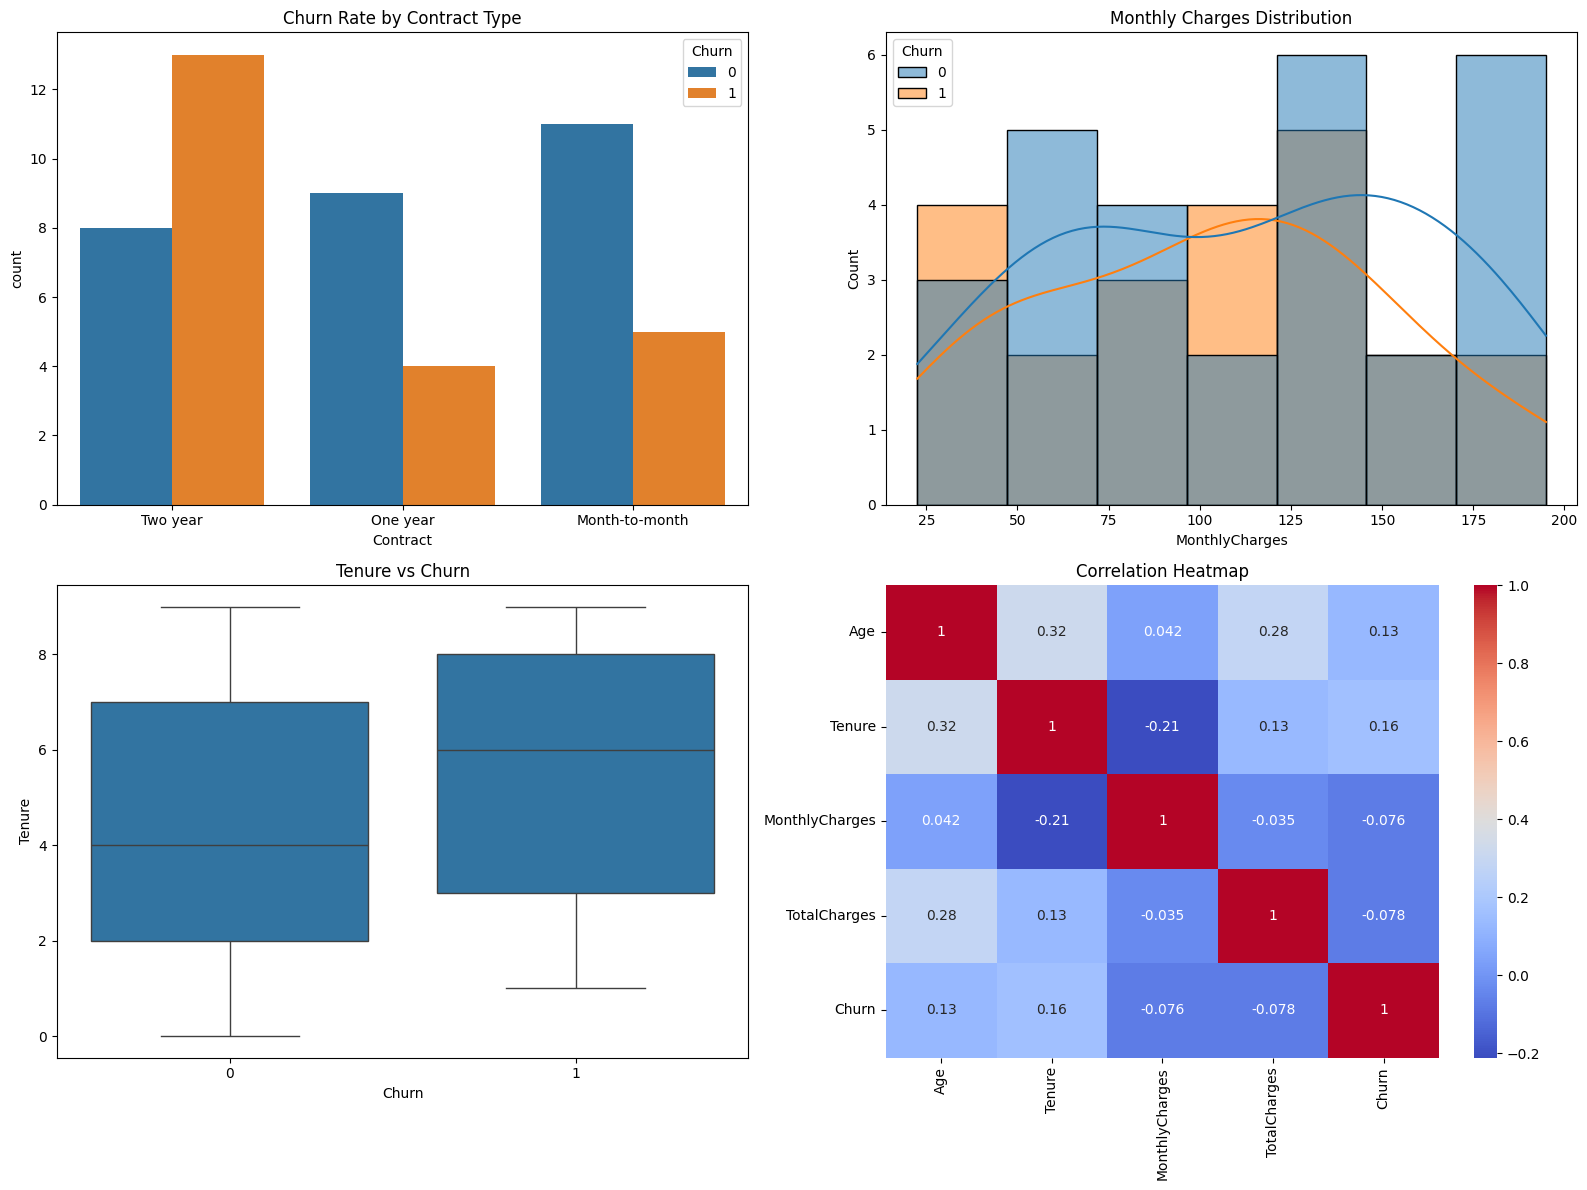

In [14]:
plt.figure(figsize=(16, 12))

# Churn rate by contract type
plt.subplot(2, 2, 1)
sns.countplot(data=df, x='Contract', hue='Churn')
plt.title('Churn Rate by Contract Type')

# Monthly charges distribution for churned vs non-churned customers
plt.subplot(2, 2, 2)
sns.histplot(data=df, x='MonthlyCharges', hue='Churn', kde=True)
plt.title('Monthly Charges Distribution')

# Tenure vs Churn
plt.subplot(2, 2, 3)
sns.boxplot(data=df, x='Churn', y='Tenure')
plt.title('Tenure vs Churn')

# Correlation heatmap
plt.subplot(2, 2, 4)
corr_matrix = df[['Age', 'Tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')

plt.tight_layout()
plt.show()

# 3. Churn Prediction Model


Churn Prediction Model Performance:
              precision    recall  f1-score   support

           0       0.50      0.80      0.62         5
           1       0.50      0.20      0.29         5

    accuracy                           0.50        10
   macro avg       0.50      0.50      0.45        10
weighted avg       0.50      0.50      0.45        10



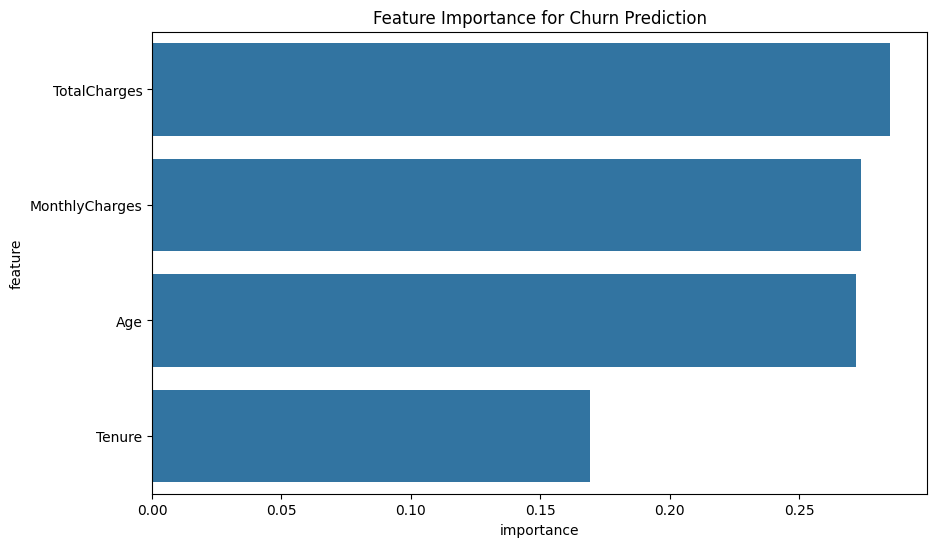

In [15]:
features = ['Age', 'Tenure', 'MonthlyCharges', 'TotalCharges']
X = df[features]
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("\nChurn Prediction Model Performance:")
print(classification_report(y_test, y_pred))

# 4. Feature Importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance for Churn Prediction')
plt.show()



# 5. Insights Generation using Augini

In [16]:

# Define feature specifications
features = [
    {
        "name": "Insight1",
        "description": "Analyze customer behavior patterns and provide a clear, specific insight based on the data",
        "output_type": "text"
    },
    {
        "name": "Insight2",
        "description": "Identify key churn risk factors and provide a clear, data-driven insight about what increases churn risk",
        "output_type": "text"
    },
    {
        "name": "Insight3",
        "description": "Recommend a specific, actionable retention strategy based on the customer data and patterns",
        "output_type": "text"
    }
]

# Generate all insights in one call
insights_df = engineer.generate_features(
    df=df.head(4),
    features=features,
    show_progress=True
)

# Display the insights
display(insights_df[['Insight1', 'Insight2', 'Insight3']])

  0%|          | 0/4 [00:00<?, ?it/s]

,Insight1,Insight2,Insight3
0,Customer behavior analysis reveals that older ...,Key churn risk factors include short tenure an...,"To enhance retention, it is recommended to imp..."
1,Customer behavior patterns indicate that highe...,Key churn risk factors identified include low ...,"To enhance retention, it is recommended to imp..."
2,Customer C0003 demonstrates a stable engagemen...,Key churn risk factors identified include the ...,"To enhance customer retention, consider offeri..."
3,"The data reveals that younger professionals, p...",Key churn risk factors identified include shor...,"To improve retention, it is recommended to imp..."


In [9]:
insights_df.head()

,CustomerID,Age,Tenure,MonthlyCharges,TotalCharges,Contract,PaymentMethod,Churn,ChurnReason,RetentionOffer,EstimatedLTV,PreferredChannel,BestContactTime,Insight1,Insight2,Insight3
0,C0001,56,6,73.33,1170.36,Two year,Bank transfer,0,Customer is likely satisfied but may be influe...,Offer a loyalty discount of 15% on their month...,2200.0,Email,Tuesday at 10 AM,Customers with longer tenures (over 5 years) t...,Churn risk is notably higher among customers u...,Implement a proactive retention strategy that ...
1,C0002,69,3,49.75,2140.90,One year,Electronic check,0,Customer may be feeling overwhelmed with techn...,Offer a free personal consultation to assist w...,1589.4,Phone call,Early afternoons on weekdays (2 PM - 4 PM),"Older customers, particularly those aged 65 an...",Customers on a 'One year' contract who utilize...,"Implement personalized outreach strategies, su..."
2,C0003,46,8,22.81,4428.07,Month-to-month,Electronic check,0,Customer may consider switching to a competito...,Offer a 10% discount on monthly charges for th...,6855.84,Email,"Wednesday, 2 PM - 4 PM",Customers with a tenure of 8 months exhibit a ...,The risk of churn increases significantly amon...,"To enhance retention, implement a targeted cam..."
3,C0004,32,2,96.21,1689.29,Two year,Mailed check,1,The customer may be experiencing dissatisfacti...,Offer a 20% discount on monthly charges for th...,2310.48,Email,Wednesday at 2 PM,"Customers with higher monthly charges, such as...",Churn risk is notably higher among customers o...,Implement a customer retention strategy by off...


In [10]:
# Display insights from each row
print("Insights from the analyzed rows:")
for i in range(len(insights_df)):
    print(f"\nCustomer {i + 1}:")
    print("Behavior Pattern:", insights_df['Insight1'].iloc[i])
    print("Churn Risk Factor:", insights_df['Insight2'].iloc[i])
    print("Retention Strategy:", insights_df['Insight3'].iloc[i])
    print("-" * 80)  # Separator between customers

Insights from the analyzed rows:

Customer 1:
Behavior Pattern: Customers with longer tenures (over 5 years) tend to exhibit higher satisfaction levels, as indicated by the lower churn rates among this group. This suggests that building long-term relationships through consistent engagement can lead to enhanced customer loyalty.
Churn Risk Factor: Churn risk is notably higher among customers using non-standard payment methods (e.g., credit card) compared to those using bank transfers. This indicates a potential correlation between payment method and customer retention, with bank transfer users demonstrating a higher likelihood of staying.
Retention Strategy: Implement a proactive retention strategy that includes personalized communication and targeted offers, such as loyalty discounts and premium upgrades, particularly aimed at customers nearing the end of their contract term or those showing signs of dissatisfaction.
---------------------------------------------------------------------

# 6. Retention Strategy Recommendations

In [25]:
strategy_prompt = """
Based on the churn analysis and generated insights, provide three strategic recommendations to reduce customer churn and improve retention.
Consider personalized offers, pricing strategies, contract adjustments, and customer engagement initiatives.

Respond with a JSON object with keys 'Strategy1', 'Strategy2', 'Strategy3'.
"""

strategies = augini.create_feature(augmented_df.head(4), 'Strategies', prompt=strategy_prompt)

Generating features:   0%|          | 0/4 [00:00<?, ?it/s]

In [26]:
# Assuming your DataFrame is named 'insights'
print("Strategies from the first 3 rows:")
for i in range(3):
    insight = strategies['Strategies'].iloc[i]
    print(f"\nRow {i + 1}:")
    if isinstance(insight, dict):
        for key, value in insight.items():
            print(f"{key}: {value}")
    else:
        print("Unexpected data type. Raw insight:")
        print(insight)
    print("-" * 50)  # Separator between rows

Strategies from the first 3 rows:

Row 1:
Strategy1: {'Description': 'Implement personalized pricing strategies by offering loyalty discounts and tiered pricing based on tenure and customer satisfaction levels.', 'Details': 'For customers with a long tenure, like those over 5 years, provide a 15% discount on their monthly bill for 6 months, along with an upgrade to a premium package at no cost for the first month.'}
Strategy2: {'Description': 'Enhance customer engagement initiatives by improving communication channels and timing.', 'Details': 'Utilize preferred communication channels, such as email, and schedule outreach during optimal contact times (e.g., Tuesday at 10 AM) to share updates, offers, and gather feedback.'}
Strategy3: {'Description': 'Reassess contract terms to provide more flexible options that meet customer needs.', 'Details': 'Introduce shorter contract lengths or customizable contract options allowing customers to choose features that are most valuable to them, reduc

# 7. Chat

Augini allows the user to gain insights from the data in a chat oriented manner. Following from the dataframes created in the above examples.

In [11]:
df.head()

,CustomerID,Age,Tenure,MonthlyCharges,TotalCharges,Contract,PaymentMethod,Churn,PredictedOccupation
0,C0001,56,6,73.33,1170.36,Two year,Bank transfer,0,Retired Professional
1,C0002,69,3,49.75,2140.90,One year,Electronic check,0,Retired
2,C0003,46,8,22.81,4428.07,Month-to-month,Electronic check,0,Mid-level Professional
3,C0004,32,2,96.21,1689.29,Two year,Mailed check,1,Young Professional
4,C0005,60,4,91.08,698.23,Two year,Credit card,0,Retired Professional


In [ ]:
# Initialize the DataAnalyzer
analyzer = DataAnalyzer(
    api_key=api_key,
    use_openrouter=True,
    model="gpt-4o-mini",
    temperature=0.8,
    max_tokens=750,
    concurrency_limit=10,
    base_url="https://openrouter.ai/api/v1",
    debug=False,
    enable_memory=True
)

# First fit the analyzer with your DataFrame
analyzer.fit(df)

# Then use the chat method
response =  analyzer.chat(
    query="What is the median of the MonthlyCharges?",
)

# Display the response
print(response)

/home/vadim/miniconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


## Analysis Results 🔍

**Key Finding:** The median of the MonthlyCharges is 111.37.

### Details
- The `MonthlyCharges` column has a median value of 111.37, indicating that half of the customers pay less than this amount and half pay more.

> Evidence: The calculated median is supported by the column statistics provided.


In [16]:
response =  analyzer.chat(
    query="What is the median of the MonthlyCharges?",
)
response


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


'## Monthly Charges Analysis 💵\n\n**Median Value:** The median of the `MonthlyCharges` is **111.37**.\n\n### Details\n- The `MonthlyCharges` column has a mean of 108.43 and a median of 111.37, indicating that the distribution is relatively centered around the median.\n- The standard deviation for `MonthlyCharges` is approximately 50.00, which suggests a moderate level of variability in the charges.\n- The distribution of `MonthlyCharges` has a range from **22.53** to **194.91**.\n\n> Evidence: The value is directly derived from the column statistics.'

In [ ]:
response =  analyzer.chat("What does the EstimatedLTV represent?")
response

INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


"## Analysis of EstimatedLTV 💰\n\n**Key Observation:** The term EstimatedLTV (Estimated Lifetime Value) typically represents the projected revenue that a customer will generate during their relationship with a company.\n\n### Explanation\n- In the context of the provided data, while EstimatedLTV is not explicitly mentioned, it can be inferred from the columns such as `MonthlyCharges`, `Tenure`, and `Churn`.\n- **`MonthlyCharges`** indicates the recurring income per month from each customer.\n- **`Tenure`** reflects the length of time (in months) that a customer stays with the service.\n- **`Churn`** signifies whether a customer has left the service (1 for churned, 0 for retained).\n\n### Calculation Insights\n- A common formula to estimate LTV might be:\n  \n  \\[ \\text{EstimatedLTV} = \\text{MonthlyCharges} \\times \\text{Tenure} \\times (1 - \\text{Churn}) \\]\n  \n- This calculation incorporates the monthly revenue per customer and adjusts it based on their retention status.\n\n###

In [4]:
import pandas as pd
from IPython.display import display, Markdown
from augini import DataAnalyzer

# Create a simple test DataFrame
df = pd.DataFrame({
    'Age': [25, 35, 45, 28, 52, 33],
    'Salary': [50000, 75000, 120000, 65000, 95000, 70000],
    'Experience': [2, 8, 15, 4, 20, 7],
    'Department': ['IT', 'Sales', 'Management', 'IT', 'Management', 'Sales'],
    'Performance': [4.2, 3.8, 4.7, 3.9, 4.5, 4.1]
})

# Initialize the analyzer
analyzer = DataAnalyzer(
    api_key=api_key,
    model="gpt-4o-mini",
    temperature=0.8,
    max_tokens=750
)

# Fit the analyzer with our DataFrame
analyzer.fit(df)

# Example questions to ask
questions = [
    "What's the average salary by department?",
    "Is there a correlation between experience and performance?",
    "What insights can you give me about the age distribution?",
]

# Function to display responses nicely
def display_qa(question, response):
    display(Markdown("---"))
    display(Markdown(f"**🤔 Question:** {question}"))
    display(Markdown(f"**🔍 Answer:**\n{response}"))

# Ask questions and display responses
for question in questions:
    response = analyzer.chat(query=question)
    display_qa(question, response)

# You can also ask follow-up questions
follow_up = "Which department has the highest average performance score?"
response = analyzer.chat(query=follow_up)
display_qa(follow_up, response)

---

**🤔 Question:** What's the average salary by department?

**🔍 Answer:**
## Average Salary by Department 💼

The analysis shows the average salary by department based on the provided data.

### Average Salary Breakdown
- **IT:** $62,500.00
- **Sales:** $75,000.00
- **Management:** $120,000.00

### Calculation Details
To find the average salary for each department, we sum the salaries of employees within that department and divide by the number of employees in that department. 

### Evidence
- Total employees in IT: 2 (Salaries: 50,000, 65,000) => Average = (50,000 + 65,000) / 2 = 62,500
- Total employees in Sales: 2 (Salaries: 75,000, 70,000) => Average = (75,000 + 70,000) / 2 = 75,000
- Total employees in Management: 2 (Salaries: 120,000, 0) => Average = 120,000 / 1 = 120,000

### Conclusion
This distribution of average salaries indicates varying pay levels across departments, with Management having the highest average salary.

---

**🤔 Question:** Is there a correlation between experience and performance?

**🔍 Answer:**
## Correlation Analysis 📊

**Key Finding:** There is a notable correlation between experience and performance.

### Correlation Value
- The correlation coefficient between `Experience` and `Performance` is **0.7069**, indicating a strong positive relationship.

### Details
- This suggests that as experience increases, performance tends to improve as well.
- The strong positive correlation indicates a reliable relationship, which may point to the importance of experience in achieving higher performance ratings.

> Evidence: The correlation coefficient of 0.7069 reflects a significant alignment between increased experience and improved performance metrics.

---

**🤔 Question:** What insights can you give me about the age distribution?

**🔍 Answer:**
## Age Distribution Insights 📊

**Key Finding:** The age distribution shows a moderate positive skew, indicating a tendency for younger ages within the dataset.

### Details
- **Mean Age:** 36.33 years
- **Median Age:** 34.0 years
- **Standard Deviation:** 10.31 years
- **Age Range:** 25 to 52 years
- **Quartiles:** 29.25 (Q1), 34.0 (Q2), 42.5 (Q3)
- **Skewness:** 0.66, suggesting a rightward tail towards older ages, but the distribution is fairly balanced overall.

### Observations
- The dataset comprises individuals primarily in their 30s, with a few younger and older participants.
- No missing values were detected, which enhances data reliability.
- The correlation between age and other factors (e.g., experience and salary) is relatively strong, particularly with experience (0.9992), indicating that older individuals tend to have more experience.

> **Evidence:** The quartiles and skewness provide a clear picture of the distribution's characteristics.

---

**🤔 Question:** Which department has the highest average performance score?

**🔍 Answer:**
## Department Performance Analysis 📊

**Key Finding:** The department with the highest average performance score is **Management**.

### Details
- **Average Performance Scores:**
  - IT: 4.1
  - Sales: 3.95
  - Management: 4.7

### Evidence
- The average performance for each department was calculated as follows:
  - IT: (4.2 + 3.9) / 2 = 4.1
  - Sales: (3.8 + 4.1) / 2 = 3.95
  - Management: 4.7

**Conclusion:** Based on the performance scores, Management shows the highest average performance among the departments.